# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

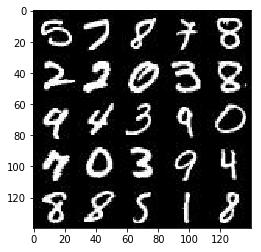

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

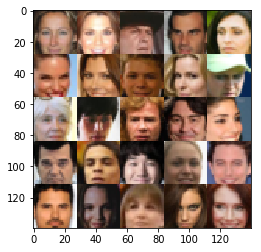

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0102... Generator Loss: 5.1716
Epoch 1/2... Discriminator Loss: 3.5029... Generator Loss: 0.1175
Epoch 1/2... Discriminator Loss: 0.2311... Generator Loss: 2.8126
Epoch 1/2... Discriminator Loss: 0.1101... Generator Loss: 5.4361
Epoch 1/2... Discriminator Loss: 2.1881... Generator Loss: 4.8634
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 0.9321
Epoch 1/2... Discriminator Loss: 0.4117... Generator Loss: 2.0796
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.7591
Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 1.6000
Epoch 1/2... Discriminator Loss: 0.3790... Generator Loss: 2.7533


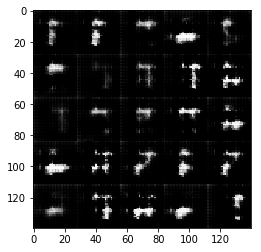

Epoch 1/2... Discriminator Loss: 0.3187... Generator Loss: 2.7396
Epoch 1/2... Discriminator Loss: 0.8796... Generator Loss: 1.7532
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 3.4464
Epoch 1/2... Discriminator Loss: 0.8231... Generator Loss: 0.8170
Epoch 1/2... Discriminator Loss: 0.8596... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 0.9753... Generator Loss: 2.3581
Epoch 1/2... Discriminator Loss: 1.5407... Generator Loss: 6.3949
Epoch 1/2... Discriminator Loss: 0.6093... Generator Loss: 2.0017
Epoch 1/2... Discriminator Loss: 0.6837... Generator Loss: 1.3312
Epoch 1/2... Discriminator Loss: 0.3363... Generator Loss: 3.5579


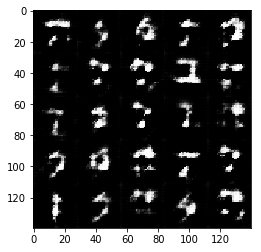

Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 1.1298
Epoch 1/2... Discriminator Loss: 0.5931... Generator Loss: 2.7460
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 1.0264
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 2.4087
Epoch 1/2... Discriminator Loss: 0.5991... Generator Loss: 3.5617
Epoch 1/2... Discriminator Loss: 0.9853... Generator Loss: 2.7890
Epoch 1/2... Discriminator Loss: 0.8103... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 2.9833
Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 1.9022
Epoch 1/2... Discriminator Loss: 0.9094... Generator Loss: 0.9084


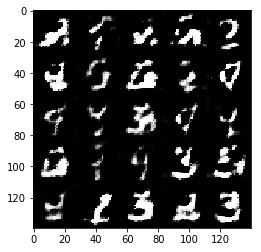

Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 0.7853... Generator Loss: 1.1961
Epoch 1/2... Discriminator Loss: 0.8343... Generator Loss: 1.2873
Epoch 1/2... Discriminator Loss: 0.8195... Generator Loss: 2.3651
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.8858
Epoch 1/2... Discriminator Loss: 0.7238... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 1.9195
Epoch 1/2... Discriminator Loss: 1.5443... Generator Loss: 1.8916


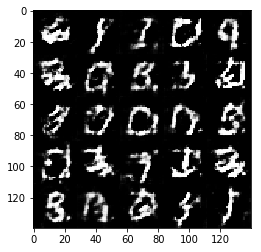

Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 1.4802
Epoch 1/2... Discriminator Loss: 0.8406... Generator Loss: 1.2022
Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.5583
Epoch 1/2... Discriminator Loss: 1.0344... Generator Loss: 0.8673
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 0.8668
Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 1.1343
Epoch 1/2... Discriminator Loss: 0.8688... Generator Loss: 1.4891
Epoch 1/2... Discriminator Loss: 1.7781... Generator Loss: 3.6724


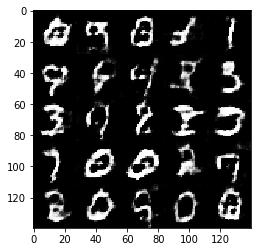

Epoch 1/2... Discriminator Loss: 1.1822... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 1.6448... Generator Loss: 0.3105
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.4440
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.5093
Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 0.7309
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 0.9860
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 2.6678
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 1.1088
Epoch 1/2... Discriminator Loss: 0.6362... Generator Loss: 1.6906
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 3.6085


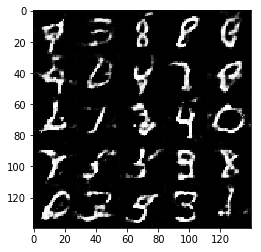

Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.7826
Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 1.3541
Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 2.0913
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 1.5489
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 1.6036
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 1.6404
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 2.4097
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 2.6156


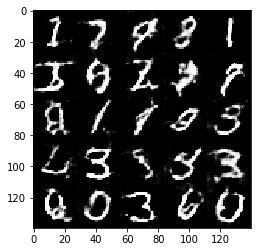

Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 1.0099
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.5164
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 1.7166
Epoch 1/2... Discriminator Loss: 1.6482... Generator Loss: 0.3458
Epoch 1/2... Discriminator Loss: 0.8913... Generator Loss: 1.0956
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.9175
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.8430
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 2.7839
Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 2.5858


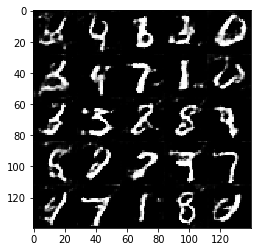

Epoch 1/2... Discriminator Loss: 0.5966... Generator Loss: 1.7098
Epoch 1/2... Discriminator Loss: 1.7059... Generator Loss: 0.3546
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.7143
Epoch 1/2... Discriminator Loss: 0.8193... Generator Loss: 0.9915
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 2.6065
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 1.6705
Epoch 1/2... Discriminator Loss: 1.1057... Generator Loss: 1.0918
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 0.9085


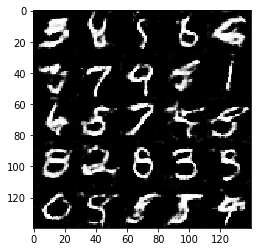

Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 1.2531
Epoch 1/2... Discriminator Loss: 1.1619... Generator Loss: 0.6445
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.2481
Epoch 2/2... Discriminator Loss: 1.8667... Generator Loss: 0.3062
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 1.6957
Epoch 2/2... Discriminator Loss: 1.5611... Generator Loss: 0.3512
Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 1.9374
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.0844


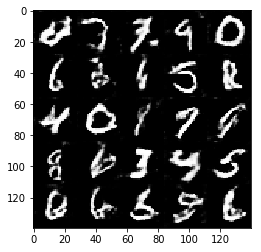

Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 2.1942
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.5843
Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.4192
Epoch 2/2... Discriminator Loss: 0.8492... Generator Loss: 1.8853
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 1.6307... Generator Loss: 0.4246
Epoch 2/2... Discriminator Loss: 1.1126... Generator Loss: 0.7140
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.1578


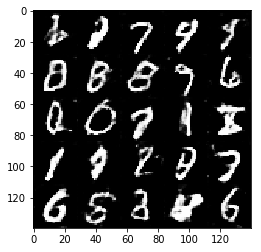

Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.2291
Epoch 2/2... Discriminator Loss: 1.9005... Generator Loss: 0.2314
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 1.6344
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.5917
Epoch 2/2... Discriminator Loss: 1.0768... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.5338
Epoch 2/2... Discriminator Loss: 1.7653... Generator Loss: 0.3207
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.4715
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 0.9639
Epoch 2/2... Discriminator Loss: 0.8423... Generator Loss: 1.5473


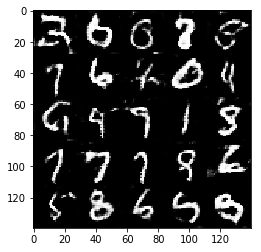

Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.6090
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.2117
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.5884
Epoch 2/2... Discriminator Loss: 1.4777... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 0.9495... Generator Loss: 1.1295
Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.4227
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 0.7655
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.4687
Epoch 2/2... Discriminator Loss: 1.7647... Generator Loss: 0.3193
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 0.9552


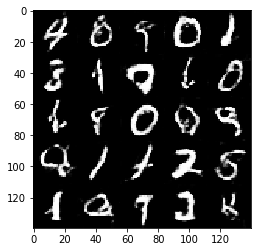

Epoch 2/2... Discriminator Loss: 1.4990... Generator Loss: 0.4449
Epoch 2/2... Discriminator Loss: 0.9113... Generator Loss: 1.1112
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 1.1979
Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 0.5381
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 0.7332
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 1.3000
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 1.1862
Epoch 2/2... Discriminator Loss: 0.9503... Generator Loss: 1.1258
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 0.5535... Generator Loss: 1.5267


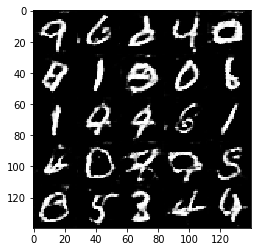

Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 4.1934... Generator Loss: 5.8991
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.0201
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 1.6033
Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 0.7681... Generator Loss: 1.2464
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 1.5622
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.4493
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 0.6052... Generator Loss: 1.1918


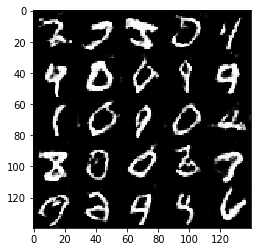

Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.5594
Epoch 2/2... Discriminator Loss: 0.7445... Generator Loss: 1.2633
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 2.2392
Epoch 2/2... Discriminator Loss: 2.1395... Generator Loss: 4.3177
Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 0.7416
Epoch 2/2... Discriminator Loss: 1.5129... Generator Loss: 0.3943
Epoch 2/2... Discriminator Loss: 1.5463... Generator Loss: 0.3362
Epoch 2/2... Discriminator Loss: 0.8640... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 2.2971
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 1.6011


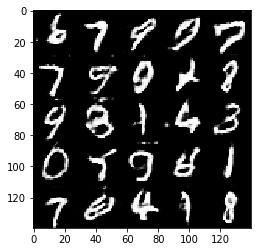

Epoch 2/2... Discriminator Loss: 0.6491... Generator Loss: 1.8424
Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 2.7173
Epoch 2/2... Discriminator Loss: 1.0688... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 0.4645... Generator Loss: 1.5487
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 0.7692
Epoch 2/2... Discriminator Loss: 2.1386... Generator Loss: 0.2518
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.2088
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 0.7759
Epoch 2/2... Discriminator Loss: 1.6783... Generator Loss: 0.3417


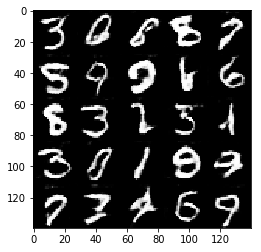

Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 1.6167
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.7106
Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.6342
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.0795
Epoch 2/2... Discriminator Loss: 0.7226... Generator Loss: 1.8263
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.5166
Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 1.3689
Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 1.6636
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 0.6327


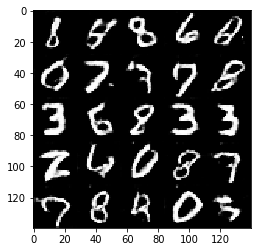

Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 1.8468
Epoch 2/2... Discriminator Loss: 1.6823... Generator Loss: 0.3990
Epoch 2/2... Discriminator Loss: 1.8008... Generator Loss: 4.5308
Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 1.1954
Epoch 2/2... Discriminator Loss: 1.0070... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 1.1488... Generator Loss: 0.5694
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.4039


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1969... Generator Loss: 7.9525
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 3.7914
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 6.6519
Epoch 1/1... Discriminator Loss: 6.0943... Generator Loss: 0.1239
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.4680
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 1.8681
Epoch 1/1... Discriminator Loss: 0.2731... Generator Loss: 2.3712


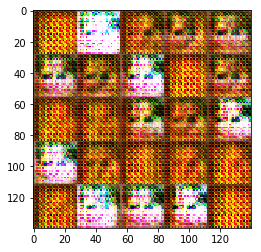

Epoch 1/1... Discriminator Loss: 0.3068... Generator Loss: 1.7315
Epoch 1/1... Discriminator Loss: 0.3212... Generator Loss: 3.9848
Epoch 1/1... Discriminator Loss: 0.0857... Generator Loss: 4.1006
Epoch 1/1... Discriminator Loss: 0.0534... Generator Loss: 4.5950
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 3.4783
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 2.4740
Epoch 1/1... Discriminator Loss: 0.4236... Generator Loss: 1.9184
Epoch 1/1... Discriminator Loss: 5.1413... Generator Loss: 7.0016
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 1.3704


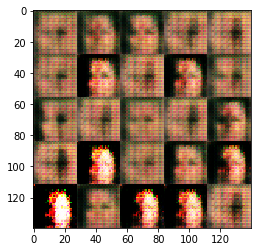

Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 1.9836
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.8001
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.6474
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 2.0427... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.6031


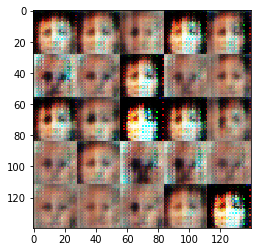

Epoch 1/1... Discriminator Loss: 0.3254... Generator Loss: 2.0652
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.9817
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.7598


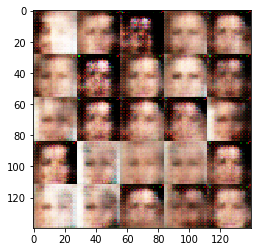

Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.8041... Generator Loss: 3.4433
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 1.4156
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 1.5831
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.5038
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 1.9307
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 0.9815


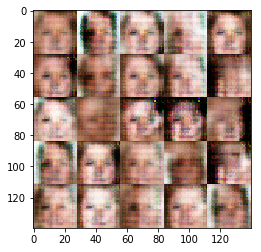

Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.6225
Epoch 1/1... Discriminator Loss: 2.3649... Generator Loss: 3.1786
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 2.0380... Generator Loss: 2.6434
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.3834
Epoch 1/1... Discriminator Loss: 2.3968... Generator Loss: 3.3525
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.0880


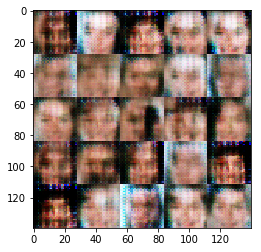

Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.9985
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.2234


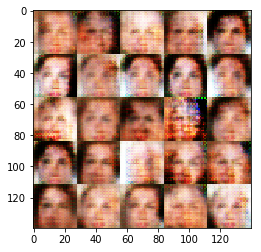

Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 1.8654... Generator Loss: 2.1314
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.2673
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 2.1169... Generator Loss: 3.6294
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.3011
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 1.8154


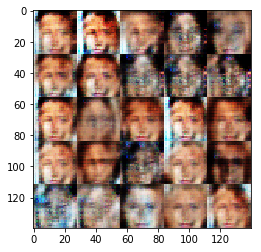

Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.6262
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.9582


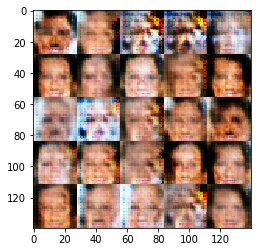

Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.3770
Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 2.7170
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.3734
Epoch 1/1... Discriminator Loss: 1.9237... Generator Loss: 3.8615
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.0771


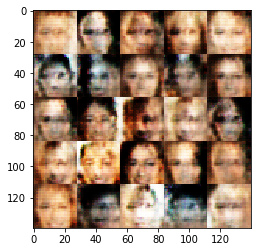

Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 2.0143
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 1.5848
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.5711
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 1.6292
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.6177


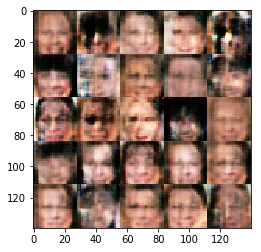

Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.9271... Generator Loss: 0.2154
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.5126
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.8415... Generator Loss: 2.6781


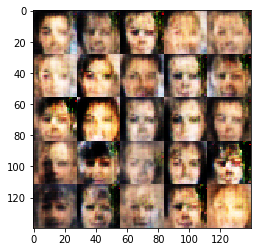

Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.6769
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 1.3343
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.3860
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.2270
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 0.7162... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.6175


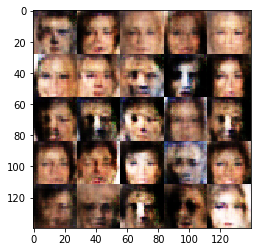

Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 2.0251
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 2.0299
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 1.4945
Epoch 1/1... Discriminator Loss: 1.6822... Generator Loss: 0.2787
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 1.3791
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.6288


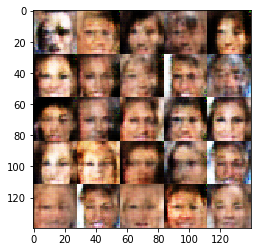

Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 2.0070
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 0.7033... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.4316
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.2847


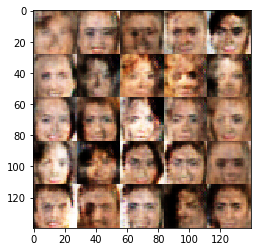

Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.4022
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.5853


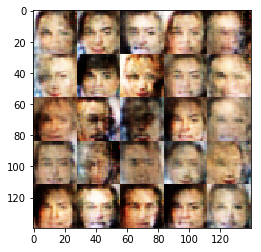

Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.8112... Generator Loss: 0.2821
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 2.1838
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.8577... Generator Loss: 0.2415
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 1.5834
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.7467


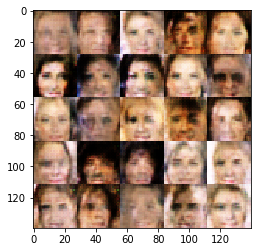

Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 2.1560
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.6764
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.3591


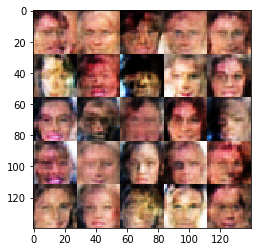

Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 0.5388... Generator Loss: 1.8909
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.7738
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 1.9990


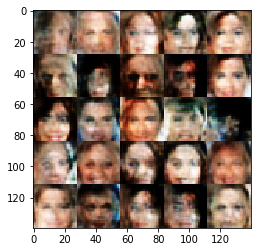

Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 2.0906
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 2.1942
Epoch 1/1... Discriminator Loss: 0.4083... Generator Loss: 2.5604
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 2.0840
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.3522
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 1.4818


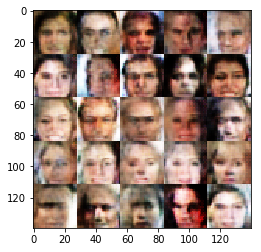

Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.9444... Generator Loss: 0.2172
Epoch 1/1... Discriminator Loss: 0.6295... Generator Loss: 1.9461
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 2.8797
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 0.9171


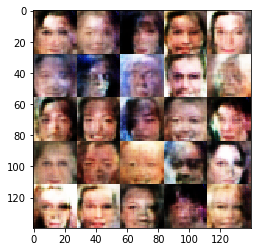

Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 2.3751
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 2.4144
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.7129
Epoch 1/1... Discriminator Loss: 0.5752... Generator Loss: 3.4590
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 3.5436
Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 1.8524
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 1.2125


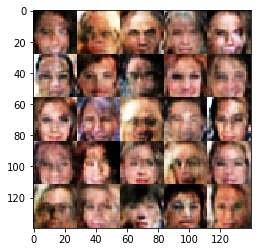

Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 1.8883
Epoch 1/1... Discriminator Loss: 2.6813... Generator Loss: 0.1019
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 1.6348
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 3.0677
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 0.6130... Generator Loss: 1.4601


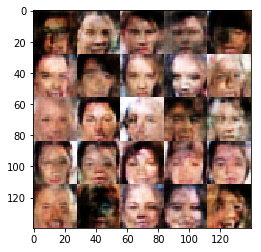

Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.8050... Generator Loss: 0.2842
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.6942... Generator Loss: 3.6615
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 1.2796
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.5413


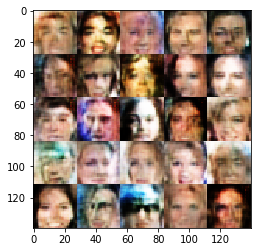

Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 0.4693... Generator Loss: 1.3526
Epoch 1/1... Discriminator Loss: 1.8232... Generator Loss: 4.4575
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 2.6604
Epoch 1/1... Discriminator Loss: 1.7426... Generator Loss: 0.2831
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 2.6135
Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 1.8761


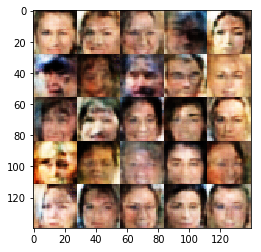

Epoch 1/1... Discriminator Loss: 1.6683... Generator Loss: 0.3136
Epoch 1/1... Discriminator Loss: 0.3159... Generator Loss: 2.8485
Epoch 1/1... Discriminator Loss: 0.2353... Generator Loss: 3.2124
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.1961
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 2.1772
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 1.6739
Epoch 1/1... Discriminator Loss: 0.1674... Generator Loss: 2.7566
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 0.1206... Generator Loss: 4.1573
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 1.1965


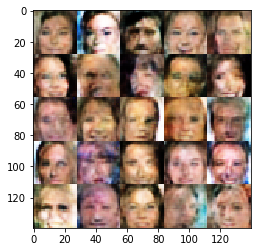

Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 2.1999
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.3355
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 0.7628... Generator Loss: 3.2874
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 3.5816
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 2.7784
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 1.9303
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 3.1008


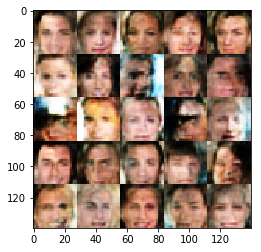

Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.7318
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 3.2511
Epoch 1/1... Discriminator Loss: 0.2715... Generator Loss: 2.0981
Epoch 1/1... Discriminator Loss: 2.4930... Generator Loss: 4.1454
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.1991
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 2.3043
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.6943


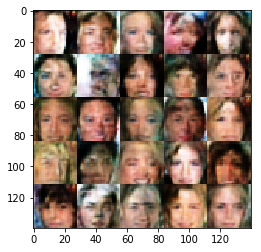

Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 2.0020
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 1.3787
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 1.8561
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 1.5234
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 2.7479
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.5748


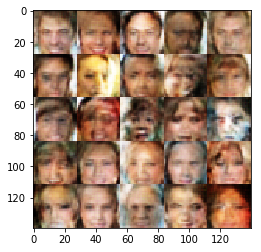

Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.4001
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.6828
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 3.9461
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 1.3535
Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 2.4073
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 0.2132... Generator Loss: 4.4435


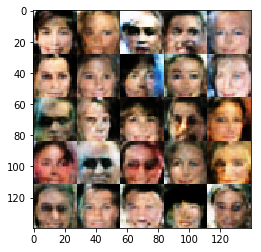

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.